In [285]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#引入k交叉验证
from sklearn.cross_validation import KFold

#引入NN
import tensorflow as tf

#引入正则表达式处理函数库
import re as re

In [334]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_x = pd.read_csv('train.csv')
train_y = train_x['Survived']

In [3]:
train_x = train_x.drop(['Ticket'] , axis=1)

In [4]:
train_x = train_x.drop(['PassengerId'] , axis = 1)

In [5]:
train_x[['Pclass' , 'Survived']].groupby('Pclass' , as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [332]:
train_x[['Sex' , 'Survived']].groupby('Sex' , as_index = False).mean().sort_values(by = 'Survived' , ascending = False)
#sort_values(by = 'Survived' , ascending = False)  显示以survived进行排序显示

,Sex,Survived
1,1,0.742038
0,0,0.188908


In [7]:
train_x[['Embarked' , 'Survived']].groupby('Embarked' , as_index = False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [42]:
train_x.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [41]:
train_x.describe(include=['O'])

,Name,Sex,Embarked
count,891,891,889
unique,891,2,3
top,"Sdycoff, Mr. Todor",male,S
freq,1,577,644


In [8]:
train_x = train_x.drop(['Cabin'] , axis=1)
#cabin feature 缺失太多 直接删除此feature

In [33]:
train_x.info()
#可以查看每个属性列的信息类型 object就是string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 62.7+ KB


In [9]:
train_x['Sex'] = train_x['Sex'].map({'male':0 , 'female':1})

In [10]:
#train_x.info()
train_x.describe(include = ['O'])

,Name,Embarked
count,891,889
unique,891,3
top,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",S
freq,1,644


In [11]:
#通过上述 发现S出现的次数最多
#所有进行缺失值填充S
train_x['Embarked'] = train_x['Embarked'].fillna('S')

In [12]:
#对age进行填充 使用均值填充
train_x['Age'] = train_x['Age'].fillna(train_x['Age'].median())

In [13]:
train_x['Embarked'] = train_x['Embarked'].map({'S':0 , 'C':1 , 'Q':2})

In [37]:
train_x['FamilySize'] = train_x['SibSp'] + train_x['Parch'] + 1

In [38]:
train_x['FamilySize'].unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11], dtype=int64)

In [54]:
#查看新增加的这个变量对survived是否有影响
train_x[['FamilySize' , 'Survived']].groupby('FamilySize' , as_index = False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [57]:
#作为对fare进行level的依据
train_x['LevelFare'] = pd.qcut(train_x['Fare'], 4)
#train_x['LevelFare'].unique()
#将fare feature处理成category类型的
#查看对target是否有影响
train_x[['LevelFare' , 'Survived']].groupby('LevelFare' , as_index = False).mean()

,LevelFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [65]:
train_x.loc[train_x['Fare']<=7.91 , 'Fare'] = 0
train_x.loc[ (train_x['Fare']>7.91) &  (train_x['Fare']<=14.454) , 'Fare'] = 1
train_x.loc[(train_x['Fare']>14.454) & (train_x['Fare']<=31.0) , 'Fare'] = 2
train_x.loc[(train_x['Fare']>31.0) & (train_x['Fare']<=512.329), 'Fare'] = 3
train_x['Fare'] = train_x['Fare'].astype(int)

In [66]:
#查看新增加feature对survived影响
train_x[['Fare' , 'Survived']].groupby('Fare' , as_index = False).mean()

,Fare,Survived
0,0.0000,0.197309
1,1.0000,0.308756
2,2.0000,0.445415
3,3.0000,0.575342
4,512.3292,1.000000


In [86]:
#对age进行level
train_x['LevelAge'] = pd.cut(train_x['Age'] , 5)

In [87]:
train_x[['LevelAge' , 'Survived']].groupby('LevelAge' , as_index = False).mean()

,LevelAge,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [90]:
train_x.loc[train_x['Age'] <=16.336 , 'Age'] = 0
train_x.loc[(train_x['Age'] >16.336) &(train_x['Age'] <=32.252) , 'Age'] = 1
train_x.loc[(train_x['Age'] >32.252) &(train_x['Age'] <=48.168) , 'Age'] = 2
train_x.loc[(train_x['Age'] >48.168) &(train_x['Age'] <=64.084) , 'Age'] = 3
train_x.loc[(train_x['Age'] >64.084) , 'Age'] = 4
train_x['Age'] = train_x['Age'].astype(int)

In [286]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    
    return ''

train_x['Title'] = train_x['Name'].apply(get_title)

In [290]:
pd.crosstab(train_x['Title'] , train_x['Survived'])
#能够查看每一个姓氏出现的频率

Survived,0,1
Title,,
Capt,1,0
Col,1,1
Countess,0,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23


In [291]:
train_x['Title'] = train_x['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

train_x['Title'] = train_x['Title'].replace('Mlle', 'Miss')
train_x['Title'] = train_x['Title'].replace('Ms', 'Miss')
train_x['Title'] = train_x['Title'].replace('Mme', 'Mrs')

In [292]:
train_x[['Title' , 'Survived']].groupby(['Title'] ,as_index = False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [293]:
train_x['Title'] = train_x['Title'].map({'Master': 1, 'Miss': 2, 'Mr': 3, 'Mrs': 4, 'Rare': 5})
train_x['Title'] = train_x['Title'].fillna(0)

In [294]:
train_x.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,LevelFare,LevelAge,Title
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,0,0,2,"(-0.001, 7.91]","(16.336, 32.252]",3
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,3,1,2,"(31.0, 512.329]","(32.252, 48.168]",4
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,1,0,1,"(7.91, 14.454]","(16.336, 32.252]",2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,3,0,2,"(31.0, 512.329]","(32.252, 48.168]",4
4,0,3,"Allen, Mr. William Henry",0,2,0,0,1,0,1,"(7.91, 14.454]","(32.252, 48.168]",3


In [295]:
#需要使用的feature
#pred_use = ['Pclass' , 'Sex' , 'Age' , 'SibSp' , 'Parch' , 'Fare' , 'Embarked']
pred_use = ['Pclass' , 'Sex' , 'Age' , 'Fare' , 'Embarked' , 'FamilySize' , 'Title']

In [15]:
def test_func(function_name = LogisticRegression):
    model = function_name()
    model.fit(train_x[pred_use] , train_y)
    
    score = model.score(train_x[pred_use] , train_y)
    
    return score

In [296]:
print('LR:',test_func(LogisticRegression))
print('RF:', test_func(RandomForestClassifier))
print('SVM:',test_func(SVC))
print('DT:',test_func(DecisionTreeClassifier))

LR: 0.791245791246
RF: 0.884399551066
SVM: 0.837261503928
DT: 0.888888888889


In [316]:
#下面使用k交叉验证

#sample数量 分为几组 随机种子
kf  = KFold(train_x.shape[0] , n_folds=3 , random_state=1)

model3 = SVC()

#train_x_train 和 train_x_vali其实就是一些数字 索引值
for train_x_train , train_x_vali in kf:
    x_ = train_x[pred_use].iloc[train_x_train , :]
    y_ = train_x['Survived'].iloc[train_x_train]
    
    model3.fit(x_ , y_)
    
    x_vali = train_x[pred_use].iloc[train_x_vali , :]
    y_vali = train_x['Survived'].iloc[train_x_vali]
    
    print('score:' , model3.score(x_vali , y_vali))

score: 0.824915824916
score: 0.83164983165
score: 0.851851851852


In [ ]:
#=================
#接下来处理test数据 submit

In [17]:
test_x = pd.read_csv('test.csv')

In [98]:
test_x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [99]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [100]:
test_x.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [105]:
test_x.describe(include = ['O'])

,Name,Sex,Embarked
count,418,418,418
unique,418,2,3
top,"Niklasson, Mr. Samuel",male,S
freq,1,266,270


In [18]:
test_x = test_x.drop(['Ticket' , 'Cabin'] , axis=1)

In [19]:
test_x['Sex'] = test_x['Sex'].map({'male':0 , 'female':1})

In [20]:
test_x['Age'] = test_x['Age'].fillna(test_x['Age'].median())

In [110]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 29.5+ KB


In [21]:
test_x['Fare'] = test_x['Fare'].fillna(test_x['Fare'].median())

In [112]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 29.5+ KB


In [22]:
test_x['Embarked'] = test_x['Embarked'].map({'S':0 , 'C':1 , 'Q':2})

In [115]:
#下面全是新增加的feature处理
test_x['FamilySize'] = test_x['SibSp'] + test_x['Parch'] + 1

In [122]:
test_x['LevelFare'] = pd.qcut(test_x['Fare'] , 5)
test_x['LevelFare'].unique().sort_values()

[(-0.001, 7.796], (7.796, 11.342], (11.342, 21.196], (21.196, 46.34], (46.34, 512.329]]
Categories (5, interval[float64]): [(-0.001, 7.796] < (7.796, 11.342] < (11.342, 21.196] < (21.196, 46.34] < (46.34, 512.329]]

In [123]:
test_x.loc[test_x['Fare'] <= 7.796 ,'Fare'] = 0
test_x.loc[(test_x['Fare']> 7.796) &(test_x['Fare'] <= 11.342) ,'Fare'] = 1
test_x.loc[(test_x['Fare'] > 11.342) &(test_x['Fare'] <= 21.196) ,'Fare'] = 2
test_x.loc[(test_x['Fare'] > 21.196) &(test_x['Fare'] <= 46.34),'Fare'] = 3
test_x.loc[(test_x['Fare'] > 46.34) &(test_x['Fare'] <= 512.329),'Fare'] = 4
test_x['Fare'] = test_x['Fare'].astype(int)

In [124]:
test_x['LevelAge'] = pd.cut(test_x['Age'] , 5)
test_x['LevelAge'].unique().sort_values()

[(0.0942, 15.336], (15.336, 30.502], (30.502, 45.668], (45.668, 60.834], (60.834, 76.0]]
Categories (5, interval[float64]): [(0.0942, 15.336] < (15.336, 30.502] < (30.502, 45.668] < (45.668, 60.834] < (60.834, 76.0]]

In [125]:
test_x.loc[(test_x['Age'] <= 15.336) , 'Age'] = 0
test_x.loc[(test_x['Age'] > 15.336)&(test_x['Age'] <= 30.502) , 'Age'] = 1
test_x.loc[(test_x['Age'] > 30.502)&(test_x['Age'] <= 45.668) , 'Age'] = 2
test_x.loc[(test_x['Age'] > 45.668)&(test_x['Age'] <= 60.834) , 'Age'] = 3
test_x.loc[(test_x['Age'] >60.834 ) , 'Age'] = 4

test_x['Age'] = test_x['Age'].astype(int)

In [312]:
test_x['Title'] = test_x['Name'].apply(get_title)

test_x['Title'] = test_x['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

test_x['Title'] = test_x['Title'].replace('Mlle', 'Miss')
test_x['Title'] = test_x['Title'].replace('Ms', 'Miss')
test_x['Title'] = test_x['Title'].replace('Mme', 'Mrs')

test_x['Title'] = test_x['Title'].map({'Master': 1, 'Miss': 2, 'Mr': 3, 'Mrs': 4, 'Rare': 5})
test_x['Title'] = test_x['Title'].fillna(0)

In [317]:
model2 = SVC()
model2.fit(train_x[pred_use] , train_y)
print(model2.score(train_x[pred_use] , train_y))

0.837261503928


In [314]:
results = model2.predict(test_x[pred_use])

In [315]:
submit = pd.DataFrame({'PassengerId':test_x['PassengerId'] , 'Survived':results})
submit.to_csv('self.csv' , index = False)

In [131]:
#add function test
#查看都有什么不同的值
#print(train_x['Embarked'].unique())

#获得名字长度 作为一个feature
#直接应用一个函数 也可以传入自己的函数
#train_x['NameLength'] = train_x['Name'].apply(lambda x :len(x))

In [303]:
#====================
#神经网络试着处理一下
#====================

w_1 = tf.Variable(tf.random_normal([7 , 5]) ,dtype=tf.float32)
b_1 = tf.Variable(tf.zeros([5]) , dtype=tf.float32)

w_2 = tf.Variable(tf.random_normal([5 , 2]) ,dtype=tf.float32)
b_2 = tf.Variable(tf.zeros([2]) , dtype=tf.float32)


In [304]:
xs = tf.placeholder(tf.float32 , shape=[None , 7])
ys = tf.placeholder(tf.int32 , shape=[None , 1])

yss = tf.one_hot(ys , depth=2)
yss = tf.reshape(yss, shape=[-1 , 2])

layer1 = tf.nn.sigmoid(tf.matmul(xs , w_1) + b_1)

layer2_logits = tf.matmul(layer1 , w_2) + b_2

l2_regu = tf.contrib.layers.l2_regularizer(0.0001)
l2 = l2_regu(w_1) + l2_regu(w_2)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=layer2_logits , labels=yss)) + l2

train_step = tf.train.GradientDescentOptimizer(0.07).minimize(loss)

In [305]:
#评判标准
real = tf.nn.softmax(layer2_logits)
real_ = tf.equal(tf.argmax(real , 1) , tf.argmax(yss , 1))
acc = tf.reduce_mean(tf.cast(real_ , tf.float32))

In [330]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

start = 0
batch_size = 160

#==========
vali_feed = {xs:train_x.loc[800:891 , pred_use] , ys:train_x.loc[800:891 , ['Survived']]}
#==========

for i in range(2000):
    x_ = train_x.loc[start:start+batch_size , pred_use]
    y_ = np.array(train_x.loc[start:start+batch_size , ['Survived']])
    
    sess.run(train_step , feed_dict={xs:x_ , ys:y_})
    
    start += batch_size
    
    if start > 800:
        start = 0
    
    if i % 200 == 0:
        print(sess.run(acc , feed_dict=vali_feed))

0.67033
0.725275
0.758242
0.78022
0.802198
0.791209
0.769231
0.802198
0.813187
0.802198


In [331]:
test_full_train_feed = {xs:train_x.loc[: , pred_use] , ys:train_x.loc[: , ['Survived']]}
print(sess.run(acc , feed_dict=test_full_train_feed))

0.802469


In [325]:
get_answer = tf.argmax(real , 1)
answer = sess.run(get_answer , feed_dict={xs:test_x.loc[: , pred_use]})

In [326]:
answer.shape

(418,)

In [328]:
wtt = pd.DataFrame({'PassengerId':test_x['PassengerId'] , 'Survived':answer})

In [329]:
wtt.to_csv('self_nn.csv' , index = False)

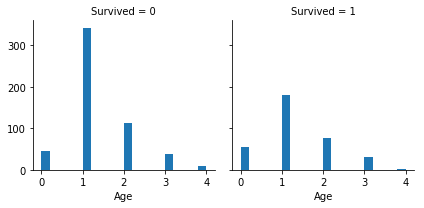

In [337]:
#===================
#===================
#图像显示
g = sns.FacetGrid(train_x , col='Survived')
g.map(plt.hist , 'Age' , bins = 20)